In [149]:
import sys
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
#!{sys.executable} -m pip install regex

In [53]:
#fj = pd.read_excel("financialjuice.xlsx")
nyt = pd.read_excel("nytimes.xlsx")
mkw = pd.read_excel("marketwatch.xlsx")
us10y = pd.read_csv("US10Y.csv")

Cleanup

In [54]:
for i,row in enumerate(us10y.values):
    if row[1]!=row[4]:
        print(i)
        break

8341


In [100]:
us10y['opcl'] = us10y['close'] - us10y['open']
us10y['opcl'] = [1 if x >0.0 else x for x in us10y['opcl']]
us10y['opcl'] =[-1 if x <0.0 else x for x in us10y['opcl']]
us10y['opcl'] = us10y['opcl'].astype(int)
us10y.head()

,Date,open,high,low,close,adjusted_close,volume,opcl
0,1980-01-02,10.482,10.482,10.482,10.482,10.482,0,0
1,1980-01-03,10.584,10.584,10.584,10.584,10.584,0,0
2,1980-01-04,10.636,10.636,10.636,10.636,10.636,0,0
3,1980-01-07,10.610,10.610,10.610,10.610,10.610,0,0
4,1980-01-08,10.553,10.553,10.553,10.553,10.553,0,0


In [132]:
us10y['cltocl'] = us10y['adjusted_close'].diff()
us10y['Date'] = us10y['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())

TypeError: strptime() argument 1 must be str, not datetime.date

In [95]:
nyt['content'] = nyt['content'].str.replace(r'&amp;', 'and', regex=True)
nyt['date'] = nyt['date'].apply(lambda a: pd.to_datetime(a).date()) 
nyt['content'] = nyt['content'].str.replace(r'http\S+','',regex=True)
nyt['content'] = nyt['content'].str.replace(r'\n','',regex=True)
nyt = nyt.drop(columns='Unnamed: 0')
nyt.head()

,date,id,content,sentim
0,2022-11-07,1589641350907150080,"“They were the poorest among the poor,” Ela Bh...",-0.8567
1,2022-11-07,1589633819912569088,"Since 2011, CUNY has more than doubled the num...",0.6124
2,2022-11-07,1589626295570285056,In today’s DealBook newsletter: @sarahfkessler...,-0.6705
3,2022-11-06,1589378360391699968,In the weekend edition of the DealBook newslet...,0.0000
4,2022-11-06,1589371060071371008,Benefit costs may go up as much as 6 percent. ...,0.4588


In [58]:
mkw['content'] = mkw['content'].str.replace(r'&amp;', 'and', regex=True)
mkw['date'] = mkw['date'].apply(lambda a: pd.to_datetime(a).date()) 
mkw['content'] = mkw['content'].str.replace(r'http\S+','',regex=True)
mkw['content'] = mkw['content'].str.replace(r'\n','',regex=True)
mkw.head()

,date,id,content
0,2022-11-07,1589481072454210048,Walgreens subsidiary nears $9 billion deal to ...
1,2022-11-07,1589474658050605056,Asian markets mostly rise as investors watch f...
2,2022-11-07,1589465485921370112,For the cost of an ad-free Netflix subscriptio...
3,2022-11-07,1589458644990661120,Fidelity launches waitlist to offer crypto tra...
4,2022-11-07,1589451879964099072,‘I can’t afford to buy candy for the neighborh...


Sentiment

In [137]:
import re
import nltk
#nltk.download('vader_lexicon') #if not up to date
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#compound =0.05<->0.05 = neutral
sia_nyt = SentimentIntensityAnalyzer()

In [138]:
def senpolarity(score):
    if(score >= 0.2):  
        return 1
    if(score <= -0.2):
        return -1 
    return 0

In [139]:
nyt['sentim'] = nyt['content'].apply(lambda x: sia.polarity_scores(x)['compound']) #use commpound portion

In [140]:
nyt['sentpol'] = nyt['sentim'].apply(lambda x: senpolarity(x))

In [141]:
new_nyt = nyt.drop(columns='id').groupby(['date']).sum().reset_index()
new_nyt.head()

,date,sentim,sentpol
0,2007-03-21,2.9718,7
1,2007-03-22,2.3240,2
2,2007-03-23,1.5471,5
3,2007-03-24,-0.8661,-2
4,2007-03-25,0.0000,0


In [146]:
merged_nyt = new_nyt.merge(us10y, how='inner', left_on='date', right_on='Date')

In [147]:
merged_nyt.head()

,date,sentim,sentpol,Date,open,high,low,close,adjusted_close,volume,opcl,cltocl
0,2007-03-21,2.9718,7,2007-03-21,4.540,4.540,4.540,4.540,4.540,0,0,-0.015
1,2007-03-22,2.3240,2,2007-03-22,4.589,4.589,4.589,4.589,4.589,0,0,0.049
2,2007-03-23,1.5471,5,2007-03-23,4.617,4.617,4.617,4.617,4.617,0,0,0.028
3,2007-03-26,0.0608,2,2007-03-26,4.607,4.607,4.607,4.607,4.607,0,0,-0.010
4,2007-03-27,-1.2714,-2,2007-03-27,4.605,4.605,4.605,4.605,4.605,0,0,-0.002


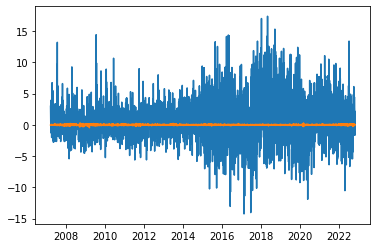

In [148]:
plt.plot(merged_nyt.date, merged_nyt.sentim)
plt.plot(merged_nyt.date, merged_nyt.cltocl)

In [153]:
def transform(row, min_col, max_col, low = -1, high=1):
    result = (row - min_col) * (high - low) / (max_col - min_col) + low;
    return result

In [154]:
column_min = min(merged_nyt['sentim'])
column_max = max(merged_nyt['sentim'])

merged_nyt['sentimScaled'] = merged_nyt['sentim'].apply(transform, min_col = column_min, max_col=column_max)

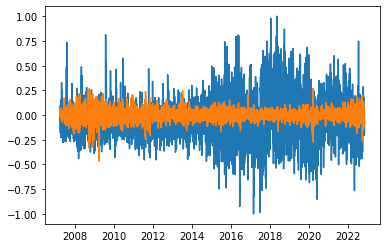

In [155]:
plt.plot(merged_nyt.date, merged_nyt.sentimScaled)
plt.plot(merged_nyt.date, merged_nyt.cltocl)

In [163]:
TP = 0
TN = 0
FP = 0
FN = 0
for i,row in enumerate(merged_nyt.values):
    if row[11]>0 and row[12]>0:
        TP += 1
    elif row[11]<0 and row[12]>0:
        FP += 1
    elif row[11]<0 and row[12]<0:
        TN += 1
    elif row[11]>0 and row[12]<0:
        FN += 1
print([[TP,FN],[FP,TN]])

[[819, 1326], [777, 1447]]


In [165]:
mkw['sentim'] = mkw['content'].apply(lambda x: sia.polarity_scores(x)['compound']) #use compound portion

In [166]:
mkw['sentpol'] = mkw['sentim'].apply(lambda x: senpolarity(x))

In [167]:
new_mkw = mkw.groupby(['date']).sum().reset_index()
new_mkw.head()

,date,id,sentim,sentpol
0,2007-01-17,15876425.0,-0.0954,0.0
1,2007-01-18,29249577.0,2.1354,5.0
2,2007-01-19,10044969.0,-0.2960,-1.0
3,2007-01-22,18493565.0,-0.3500,-2.0
4,2007-01-23,26826211.0,-0.9043,-2.0


In [168]:
merged_mkw = new_mkw.merge(us10y, how='inner', left_on='date', right_on='Date')

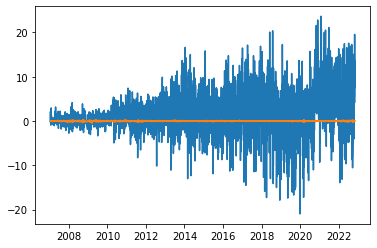

In [169]:
plt.plot(merged_mkw.date, merged_mkw.sentim)
plt.plot(merged_mkw.date, merged_mkw.cltocl)

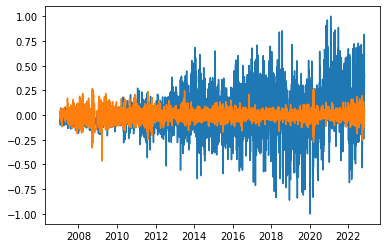

In [170]:
column_min = min(merged_mkw['sentim'])
column_max = max(merged_mkw['sentim'])
merged_mkw['sentimScaled'] = merged_mkw['sentim'].apply(transform, min_col = column_min, max_col=column_max)
plt.plot(merged_mkw.date, merged_mkw.sentimScaled)
plt.plot(merged_mkw.date, merged_mkw.cltocl)

In [171]:
TP = 0
TN = 0
FP = 0
FN = 0
for i,row in enumerate(merged_mkw.values):
    if row[11]>0 and row[12]>0:
        TP += 1
    elif row[11]<0 and row[12]>0:
        FP += 1
    elif row[11]<0 and row[12]<0:
        TN += 1
    elif row[11]>0 and row[12]<0:
        FN += 1
print([[TP,FN],[FP,TN]])

[[1239, 100], [129, 1274]]
